In [3]:
import B2D
import bitsetting
import numpy as np
import random
from skimage import io,transform
from matplotlib import pyplot as plt
from xxhash import xxh32
import nbimporter
import Toollib 
import pandas as pd
import hashlib

In [4]:
import os, re
imagelist = os.listdir('image')
imagelist = [re.sub(r'.tiff', '', i) for i in imagelist]

In [5]:
imagelist

['Baboon', 'house', 'Jet', 'Lena', 'Peppers', 'Sailboat', 'Splash', 'Tiffany']

In [6]:
import hashlib

def generate_authentication_code(gvi, rmi, bmi, i, j):
    input_string = str(gvi) + str(rmi) + str(bmi) + str(i) + str(j)
    hash_object = hashlib.md5(input_string.encode())
    hash_code = hash_object.digest()
    # 將二進位制的哈希值轉換為十進位數字
    hash_int = int.from_bytes(hash_code, byteorder='big')
    return hash_int

In [7]:
def AVGI(Graph,lr=4,lb=4):
    path = 'image/'+Graph+'.tiff'
    I=io.imread(path)
    Stego = I.copy()

    p = 0
    MSE = 0
    F = 0
    N = 0
    X = 0
    delta_RB_List = []

    for i in range(Stego.shape[0]):
        for j in range(Stego.shape[1]):
            Gray = I[i,j,0]*0.299+I[i,j,1]*0.587+I[i,j,2]*0.114
            G_round = round(Gray)
            zero_lr =np.zeros(lr)
            zero_lb =np.zeros(lb)
            Stego[i,j,0] = bitsetting.lsbset(Stego[i,j,0],zero_lr)
            Stego[i,j,2] = bitsetting.lsbset(Stego[i,j,2],zero_lb)
            
            ac = generate_authentication_code(G_round, Stego[i,j,0], Stego[i,j,1], i, j)    
            ac = Toollib.fold(ac,lr+lb)
            
            bin = B2D.Dec2Bin(ac,lr+lb)
            upper = bin[0:lr]
            lower = bin[lr:]
            
            k=[]
            Stego[i,j,0] = bitsetting.lsbset(Stego[i,j,0],upper)
            k.append(Stego[i,j,0])
            Stego[i,j,2] = bitsetting.lsbset(Stego[i,j,2],lower)  
            k.append(Stego[i,j,2])
            g_bar = int((Gray - 0.299*k[0] - 0.114*k[1])/0.587)
            
            if(round(0.299*k[0]+0.587*g_bar+0.114*k[1]) < round(Gray)):
                g_bar += 1
            elif(round(0.299*k[0]+0.587*g_bar+0.114*k[1]) > round(Gray)):
                g_bar -= 1

            if(g_bar > 255 or g_bar < 0):
                p += 1
                ac_fold = Toollib.fold(ac,2)
                Stego[i,j] = Toollib.remedy(Stego[i,j,0],Stego[i,j,1],Stego[i,j,2],ac_fold)
            else:
                Stego[i,j,1] = g_bar

            # print(f"I:{I[i,j]}, S:{Stego[i,j]}, g_bar:{(Gray - 0.299*k[0] - 0.114*k[1])/0.587}, k:{k}")

            X = 0
            delta_B = int(Stego[i,j,2]) - int(I[i,j,2])
            MSE += delta_B ** 2
            delta_G = int(Stego[i,j,1]) - int(I[i,j,1])
            MSE += delta_G ** 2 
            delta_R = int(Stego[i,j,0]) - int(I[i,j,0])
            MSE += delta_R ** 2    

            delta_RB_List.append((delta_R, delta_B))            

    MSE /= (Stego.shape[0]*Stego.shape[1]*3)
    PSNR = 10 * np.log10(65025/MSE)
    print(f"PSNR:{PSNR} , F:{p} , X:{N}")

    with open("processed_data_hong_method/"+Graph+".txt","w") as file:
        file.write(f"PSNR: {PSNR}\n")
        file.write(f"outliers: {p}")


    io.imshow(Stego)
    io.show()
    io.imsave('processed_image_hong_method/'+Graph+'.png',Stego)
    return delta_RB_List

In [8]:
def RB_histogram_Variation_Frequency(delta_RB,image):
    delta_RB_ravel = delta_RB.ravel()
    delta_RB_ravel = np.abs(delta_RB_ravel)
    bins = range(0, 16)
    counts, edges = np.histogram(delta_RB_ravel, bins=bins)
    print(counts)

    # 繪製長條圖
    plt.bar(edges[:-1], counts, width=1, edgecolor="black", align="edge")

    # 設置橫軸範圍和標籤
    # plt.xticks(range(0, 16))
    # plt.xlabel("Variation")
    # plt.ylabel("Frequency")
    # plt.title("Hong's method (2020)")
    
    plt.savefig(f"Variation-Frequency/{image}_APPM.png")
    # 顯示圖表
    plt.show()
    

PSNR:36.126214772074505 , F:12 , N:9448


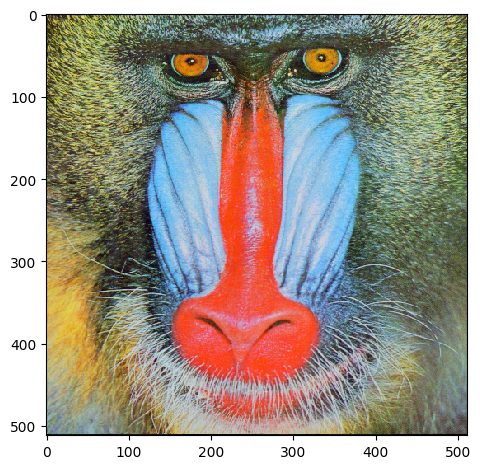

PSNR:36.145914092786946 , F:561 , N:8922


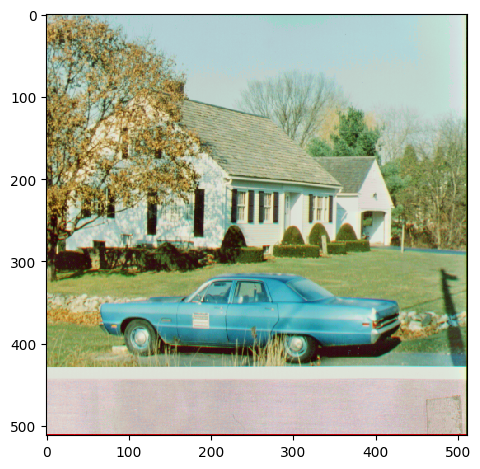

PSNR:36.0657576372427 , F:257 , N:6474


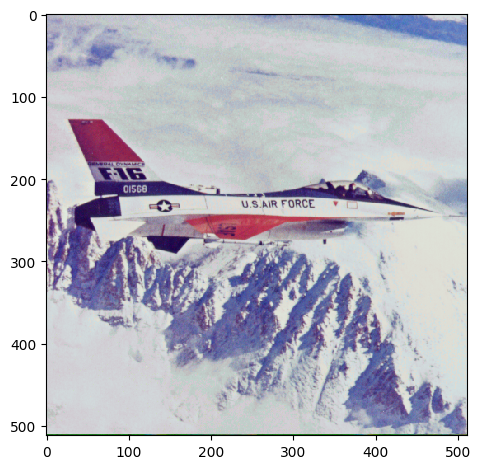

PSNR:36.07771390786017 , F:1 , N:10328


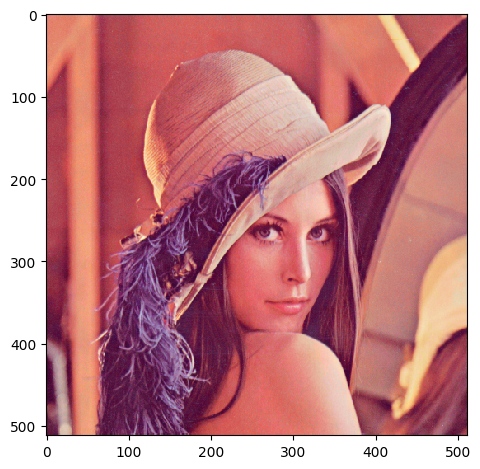

PSNR:35.95051887298045 , F:8621 , N:15334


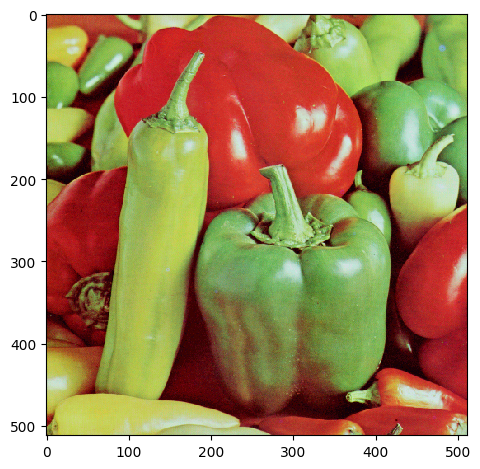

PSNR:36.18668319588694 , F:797 , N:8667


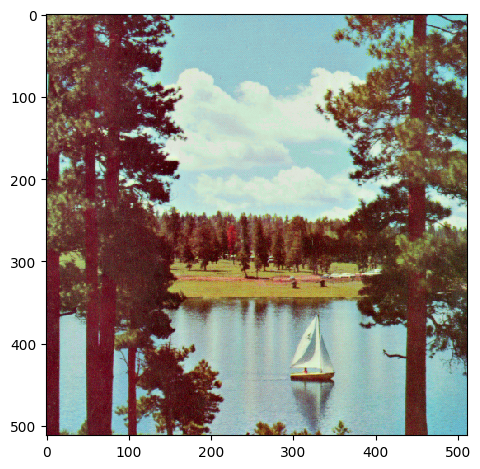

PSNR:36.12429907963111 , F:7570 , N:9381


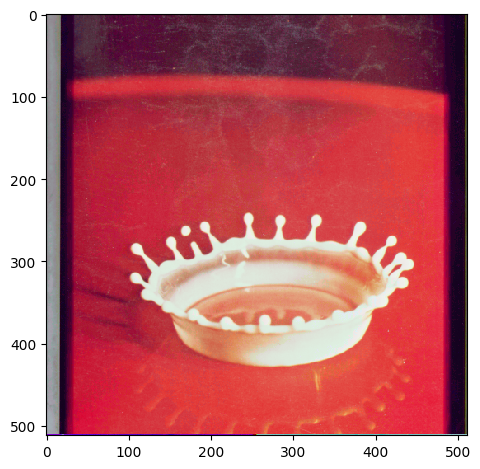

PSNR:33.168796187678126 , F:20310 , N:97648


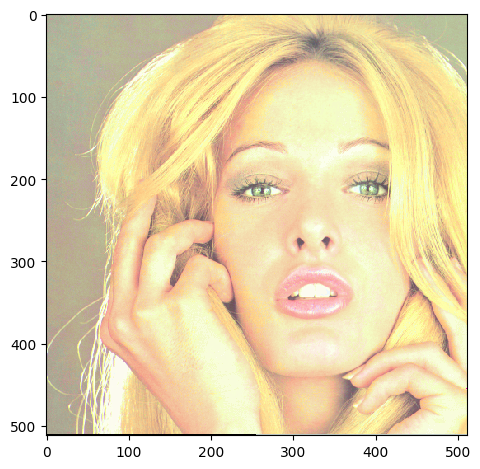

In [11]:
for image in imagelist:
    delta_RB = Toollib.AVGI(image)
    #delta_RB = np.array(delta_RB)
    #RB_histogram_Variation_Frequency(delta_RB,image)

In [ ]:
def calculate_psnr(original_image, processed_image):
    """
    計算 PSNR（峰值信噪比）
    """
    mse = np.mean((original_image - processed_image) ** 2)
    if mse == 0:
        return float('inf')  # 如果 MSE 為 0，PSNR 無限大
    max_pixel = 255.0
    psnr = 10 * np.log10((max_pixel ** 2) / mse)
    return psnr

def save_psnr_to_file(image_name, psnr, output_file):
    """
    將 PSNR 結果寫入檔案
    """
    with open(output_file, 'a') as file:
        file.write(f"Image: {image_name}, PSNR: {psnr:.2f}\n")

PSNR:36.126214772074505 , F:12 , N:9448


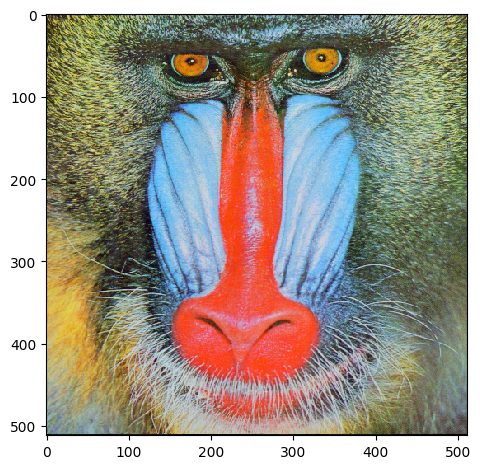

PSNR:36.145914092786946 , F:561 , N:8922


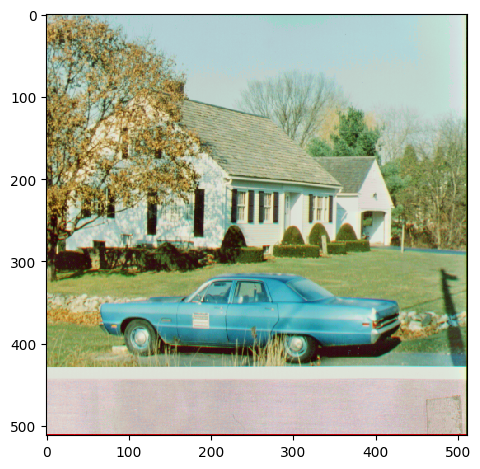

PSNR:36.0657576372427 , F:257 , N:6474


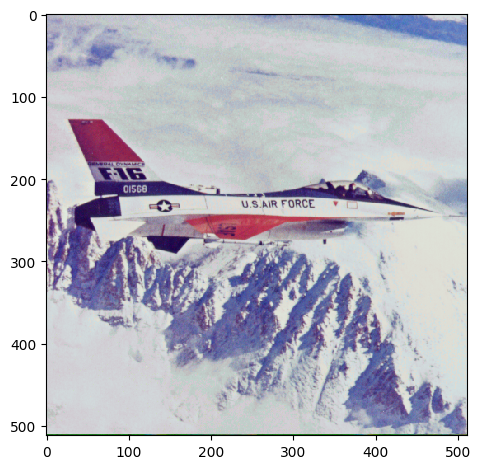

PSNR:36.07771390786017 , F:1 , N:10328


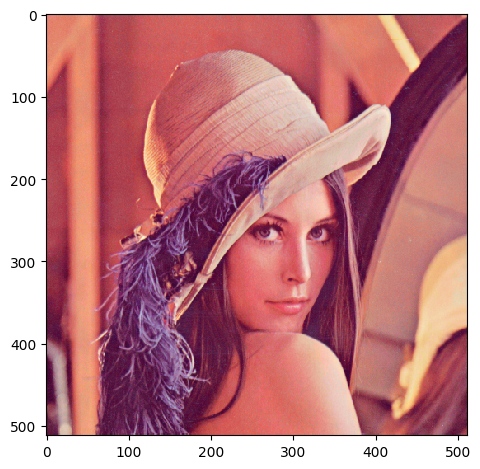

PSNR:35.95051887298045 , F:8621 , N:15334


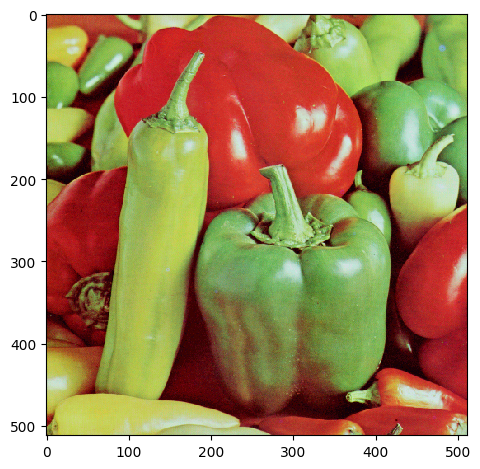

PSNR:36.18668319588694 , F:797 , N:8667


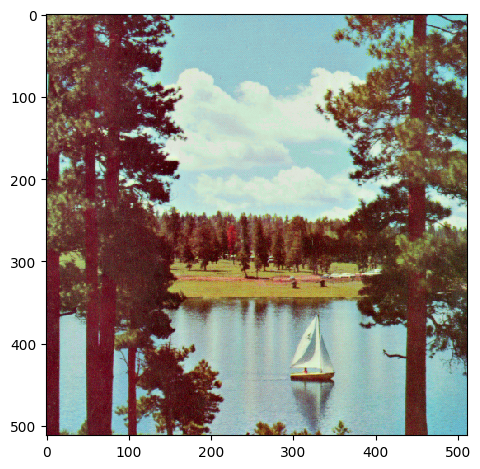

PSNR:36.12429907963111 , F:7570 , N:9381


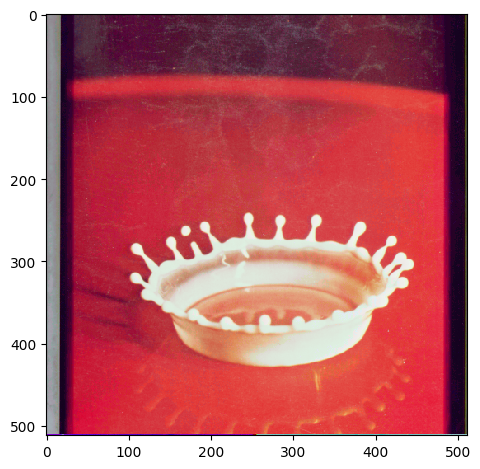

PSNR:33.168796187678126 , F:20310 , N:97648


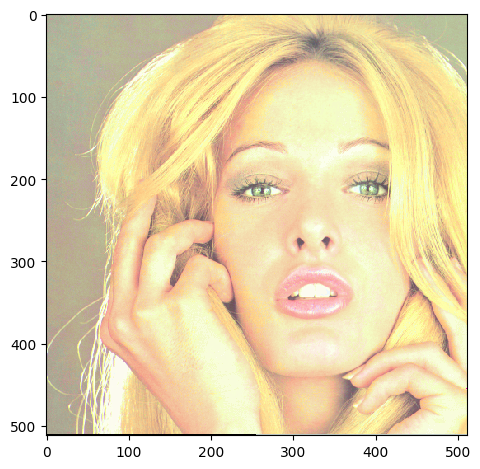

In [6]:
import mainprogram 
import Toollib
from skimage import io
import os
from importlib import reload
reload(mainprogram)

# 定義圖片目錄和圖片列表
image_dir = 'image'
image_list = [os.path.splitext(name)[0] for name in os.listdir(image_dir)]
photo = []

for name in image_list:
    photo.append(Toollib.AVGI(name)) 
       

In [ ]:
output_dir = 'processed_image_hong_method'
i = 0
for name in image_list:
    output_image_path = os.path.join(output_dir, name+'.png')
    io.imsave(output_image_path, photo[i][0])
    i+=1

In [ ]:
from PIL import Image
import numpy as np
import os

output_dir = 'processed_image_hong_method'
image_list = os.listdir(image_dir)
for i,image_name in enumerate(image_list):
    image_path = os.path.join(image_dir, image_name)
    
    # 使用 PIL 讀取 .tiff 圖片
    with Image.open(image_path) as img:
        img = img.convert('RGB')  # 確保圖像是 RGB 格式
        image = np.array(img)
    output_image_path = os.path.join(output_dir, image_name.replace('.tiff', '.png'))
    io.imsave(output_image_path, image)
    

In [ ]:
import numpy as np
original_image_dir = 'image'
processed_image_dir = 'processed_image'
output_file = 'psnr_results.txt'

for image_name in os.listdir(original_image_dir):
    original_image_path = os.path.join(original_image_dir, image_name)
    processed_image_path = os.path.join(processed_image_dir, image_name)

    # 確保影像存在於兩個目錄中
    if os.path.exists(original_image_path) and os.path.exists(processed_image_path):
        original_image = io.imread(original_image_path)
        processed_image = io.imread(processed_image_path)

        # 計算 PSNR
        psnr = calculate_psnr(original_image, processed_image)

        # 儲存結果到檔案
        save_psnr_to_file(image_name, psnr, output_file)

print(f"PSNR 計算完成，結果已儲存到 {output_file}")

PSNR 計算完成，結果已儲存到 psnr_results.txt


In [10]:
import Toollib
import importlib
importlib.reload(Toollib)

Toollib.tranform_to_grayscale(input_dir = "processing_image")
Toollib.cal_difference()

Grayscale conversion completed.
Grayscale TIFF to PNG conversion completed.
Image: Baboon.png, SSIM: 0.9981750130557073, PSNR:48.80369117937679
Image: house.png, SSIM: 0.9960638928889216, PSNR:48.931418758260754
Image: Jet.png, SSIM: 0.9945787986182172, PSNR:48.83911766737462
Image: Lena.png, SSIM: 0.9945710097342099, PSNR:48.8817229901234
Image: Peppers.png, SSIM: 0.9925811746387847, PSNR:47.49548884363954
Image: Sailboat.png, SSIM: 0.9959448007664554, PSNR:48.65892753255251
Image: Splash.png, SSIM: 0.9922927889183906, PSNR:47.693840523000176
Image: Tiffany.png, SSIM: 0.9902375447437537, PSNR:44.756882868954484
